In [13]:
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
)
from brainlit.utils.Neuron_trace import NeuronTrace

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import splev, splprep
from scipy.spatial.distance import cosine
from scipy.stats import wilcoxon, pearsonr, linregress, norm
from tqdm import tqdm
from cloudvolume import CloudVolume
from similaritymeasures import frechet_dist
import seaborn as sns
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from cloudvolume.exceptions import SkeletonDecodeError
import pickle
from copy import deepcopy
import networkx as nx
import os
from skimage import io
from matplotlib import cm
from matplotlib.colors import ListedColormap 
from turtle import color
from scipy.ndimage import distance_transform_edt

In [2]:
root_dir = Path(os.path.abspath(""))
data_dir = os.path.join(root_dir, "data", "mapping-files")

velocity_path = os.path.join(data_dir, "downloop_1_v.mat")
affine_path = os.path.join(data_dir, "downloop_1_A.mat")

ct = CloudReg_Transform(velocity_path, affine_path, direction="atlas")

integrating velocity field: 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


Range of og_coords has padding of 190microns in total

In [3]:
ara = io.imread("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif")

## Plot displacement field over atlas

In [4]:
def get_transformed_line(a,b, ct):
    ts = np.arange(0,1.01, 0.01)
    line = np.zeros((len(ts), len(a)))
    for i,t in enumerate(ts):
        line[i,:] = a + t*(b-a)
    new_line = ct.evaluate(line)
    return new_line

    


(1320, 800)


(-8000.0, 8000.0, -5000.0, 5000.0)

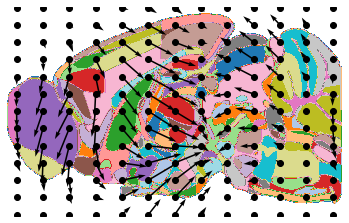

In [7]:
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

z = 600

ara_slice = np.squeeze(ara[:,:,z])
unqs = np.unique(ara_slice)

cmap = cm.get_cmap('tab20')
newcolors = cmap(np.arange(20))
newcolors = np.repeat(newcolors, 10, 0)
white = np.array([1,1,1,1])
newcolors[0,:] = white
newcmp = ListedColormap(newcolors)

for i, unq in enumerate(unqs):
    if unq != 0:
        ara_slice[ara_slice == unq] = i
print(ara_slice.shape)

fig, ax = plt.subplots()

xs = np.array([z*10 + 95])
ys = np.arange(ymin, ymax+1, (ymax - ymin) / 12)
zs = np.arange(zmin, zmax+1, (zmax - zmin) / 12)

for y in ys:
    a = np.array([xs[0], y, zmin])
    b = np.array([xs[0], y, zmax])
    new_line = get_transformed_line(a,b,ct)
    # ax.plot(new_line[:,1], new_line[:,2], c='white')

for z in zs:
    a = np.array([xs[0], ymin, z])
    b = np.array([xs[0], ymax, z])
    new_line = get_transformed_line(a,b,ct)
    # ax.plot(new_line[:,1], new_line[:,2], c='white')


og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)
diff = new_coords - og_coords



ax.imshow(ara_slice.T, extent=(-8000, 8000, -5000, 5000), cmap=newcmp)

ax.scatter(
    og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid", c="black"
)


ax.quiver(
    og_coords[:, 1],
    og_coords[:, 2],
    diff[:,1],
    diff[:,2],
    label="Scaled Displacement Field",
    color="black"
)
ax.axis('off')


## Plot Jacobian over atlas border

In [22]:
def get_border(im, border_id = 0):
    if (im < 0).any():
        raise ValueError(f"Input image cannot have negative values")
    if border_id != 0:
        im[im == 0] = -1
        im[im == border_id] = 0
    edt = distance_transform_edt(im)
    edt[edt != 1] = -1
    edt[edt == 1] = 0
    edt[edt == -1] = 1
    return edt

    

  0%|          | 0/169 [00:00<?, ?it/s]


AttributeError: 'CloudReg_Transform' object has no attribute 'Jacobian'

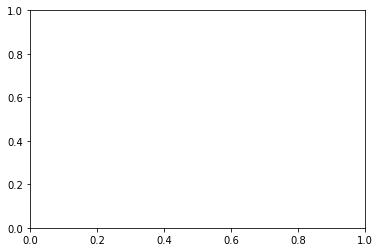

In [24]:
z = 600


fig, ax = plt.subplots()

ara_slice = np.squeeze(ara[:,:,z])
border = get_border(ara_slice)




xs = np.array([z*10 + 95])
ys = np.arange(ymin, ymax+1, (ymax - ymin) / 12)
zs = np.arange(zmin, zmax+1, (zmax - zmin) / 12)

Xs, Ys, Zs = np.meshgrid(xs, ys, zs)
XYZs = np.reshape(np.stack((Ys, Xs, Zs), axis=-1), newshape=(-1, 3))
detJs = []

for coord in tqdm(XYZs):
    J = ct.Jacobian(coord)
    detJs.append(np.linalg.det(J))

detJs = np.array(detJs)
detJs = np.reshape(detJs, newshape = Xs.shape)
print(detJs.shape)


ax.imshow(border.T, extent=(-8000, 8000, -5000, 5000), cmap='gray')
ax.axis('off')

In [16]:
np.unique(border)

array([0., 1.])